# Can all run_replicates_x() be a single function?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
from utils import (run_replicates, 
                   ecdf_norm_plotter, 
                   run_replicates_annulus)

import pints
import pints.toy
import pints.plot
from pints.functionaltests.differential_evolution \
    import (test_differential_evolution_on_two_dim_gaussian,
            test_differential_evolution_on_banana,
            test_differential_evolution_on_correlated_gaussian,
            test_differential_evolution_on_annulus)

In [2]:
import multiprocessing
multiprocessing.set_start_method('spawn')

In [3]:
iterations = np.geomspace(1100, 2000, 3)  # Same as 10*np.linspace(np.log10(lower), np.log10(upper), 2)
replicates = 10

28.71966647699992


/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


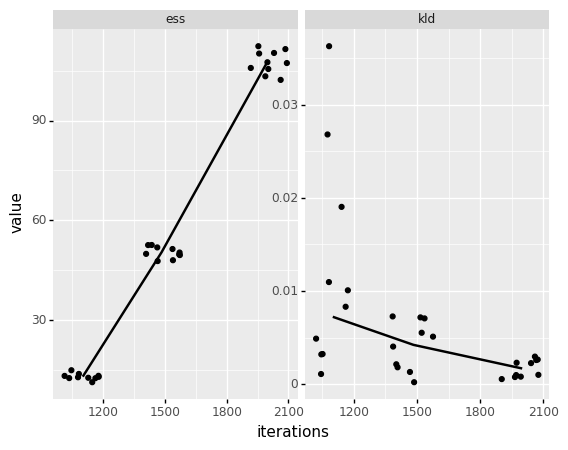

<ggplot: (8781127878879)>

In [4]:
np.random.seed(1)
t = pints.Timer()
test = run_replicates(iterations, replicates, test_differential_evolution_on_two_dim_gaussian)
print(t.time())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

28.770648633000746


/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


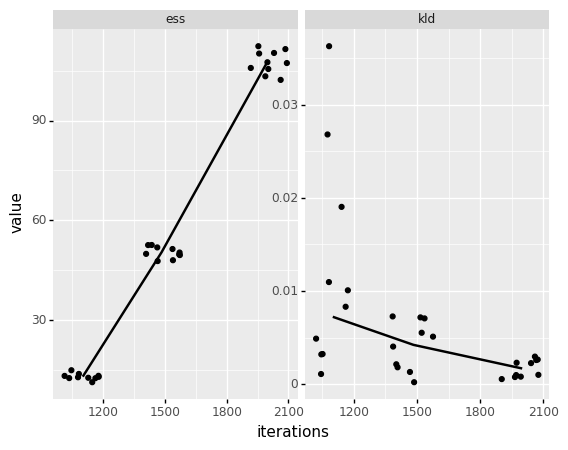

<ggplot: (8781127227374)>

In [5]:
def run_replicates2(iterations, n_replicates, test, parallel=False):
    """
    Runs ``test(i)`` for all entries ``i`` in ``iterations``, repeating each
    test ``n_replicates`` times.

    The argument ``test`` is expected to return a dictionary of (scalar valued)
    results.

    The returned value is a pandas DataFrame with
    ``len(iterations) * n_replicates`` rows. Each column contains an index, the
    number of iterations performed as ``iterations``, the index of the repeat
    as ``replicate``, followed by the entries of the corresponding test
    result.

    Parallel evaluation can be enabled by setting ``parallel`` to ``True`` or
    to the number of worker processes to use. However, this can cause issues in
    Jupyter notebooks.
    """
    df = pd.DataFrame(index=np.arange(len(iterations) * n_replicates))
    df['iterations'] = np.repeat(iterations, n_replicates)
    df['replicate'] = np.tile(np.arange(n_replicates), len(iterations))

    results = pints.evaluate(test, list(df['iterations']), parallel=parallel)
    assert len(results) > 0, 'Empty result set generated'
    for key in results[0].keys():
        df[key] = np.array([r[key] for r in results], copy=False)

    return df


np.random.seed(1)
t = pints.Timer()
test = run_replicates2(iterations, replicates, test_differential_evolution_on_two_dim_gaussian)
print(t.time())

# Rename 'mean-ess' to 'ess' so that it is plotted first.
# If plotted second, it gets different "jitter" values making the plots show differences
# even though the data is the same.
test['ess'] = test['mean-ess']
del(test['mean-ess'])

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

16
5.365114201998949


/usr/local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


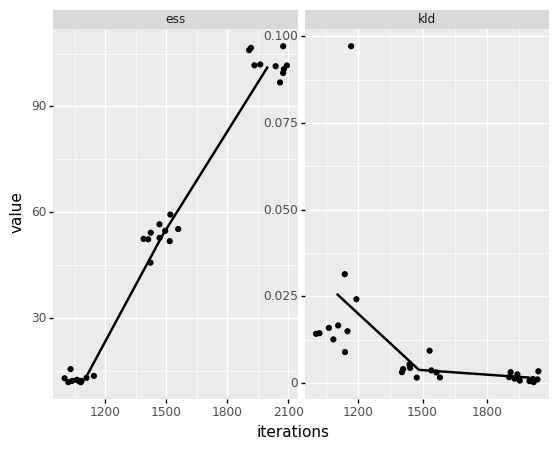

<ggplot: (8781127898950)>

In [6]:
np.random.seed(1)
t = pints.Timer()
test = run_replicates2(iterations, replicates, test_differential_evolution_on_two_dim_gaussian, parallel=True)
print(t.time())

test['ess'] = test['mean-ess']
del(test['mean-ess'])

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Please note the speed-up above is somewhat exaggerated as I convinced Gary to buy me a ridiculous computer.